In [1]:
import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices('GPU')

if gpu_devices:
    tf.config.experimental.set_visible_devices(gpu_devices[1], 'GPU')
    print(gpu_devices[1])
    print('Success')

PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Success


In [2]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from keras.models import Sequential,load_model
from keras.layers import Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator

In [3]:
# Path to your dataset
data_dir = '../Data/bone_marrow_cell_dataset'

# List to store image paths and labels
image_paths = []
labels = []

# Loop through class directories

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    
    if os.path.isdir(class_dir):
        for sub_dir_name in os.listdir(class_dir):
            sub_dir_path = os.path.join(class_dir, sub_dir_name)
            
            if os.path.isdir(sub_dir_path):
                for img_name in tqdm(os.listdir(sub_dir_path), desc=f"Processing {class_name}/{sub_dir_name}"):
                    img_path = os.path.join(sub_dir_path, img_name)
                    if os.path.isfile(img_path):
                        image_paths.append(img_path)
                        labels.append(class_name)
            else:
                img_path = os.path.join(class_dir, sub_dir_name)
                if os.path.isfile(img_path):
                    image_paths.append(img_path)
                    labels.append(class_name)
    else:
        img_path = class_dir  # For classes without subdirectories
        if os.path.isfile(img_path):
            image_paths.append(img_path)
            labels.append(class_name)

Processing EBO/24001-25000: 100%|██████████| 1000/1000 [00:00<00:00, 176565.10it/s]


In [4]:
# Splitting the data into train, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Now X_train, y_train, X_val, y_val, X_test, y_test are the organized data for training, validation, and testing
# Combine all labels from train, validation, and test sets
combined_labels = y_train + y_val + y_test

# Print all unique classes
unique_classes = set(combined_labels)
print("Unique classes:", unique_classes)

Unique classes: {'PEB', 'MYB', 'ABE', 'LYT', 'MON', 'OTH', 'MMZ', 'BAS', 'FGC', 'PMO', 'NGB', 'LYI', 'PLM', 'KSC', 'EBO', 'NGS', 'EOS', 'BLA', 'HAC', 'NIF', 'ART'}


In [5]:
from sklearn.preprocessing import LabelEncoder

# Convert string labels to numerical labels using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Calculate the number of classes directly from the labels
num_classes = len(set(combined_labels))

# Convert numerical labels to one-hot encoded vectors
y_train_onehot = to_categorical(y_train_encoded, num_classes)
y_val_onehot = to_categorical(y_val_encoded, num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes)

num_classes


21

In [6]:
# strategy = tf.distribute.MirroredStrategy()

In [7]:
# batch_size = batch_size * strategy.num_replicas_in_sync

In [8]:

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(250, 250, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# # Freeze the layers of the base model
# for layer in base_model.layers:
#     layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



# with strategy.scope():

#     base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(250, 250, 3))
#     x = base_model.output
#     x = Flatten()(x)
#     x = Dense(256, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     predictions = Dense(num_classes, activation='softmax')(x)
#     model = Model(inputs=base_model.input, outputs=predictions)

#     # Freeze the layers of the base model
#     for layer in base_model.layers:
#         layer.trainable = False

#     # Compile the model
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


2024-02-09 09:19:32.191475: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20710 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:af:00.0, compute capability: 8.6


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 125, 125, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 125, 125, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [6]:
# Preprocess images using ImageDataGenerator
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1. / 255
)


batch_size = 32

# Define a custom generator to load and preprocess images on-the-fly
def custom_generator(image_paths, labels, batch_size):
    num_samples = len(image_paths)
    while True:
        indices = np.random.choice(num_samples, size=batch_size, replace=False)
        batch_images = []
        batch_labels = []
        for idx in indices:
            img_path = image_paths[idx]
            label = labels[idx]
            try:
                img = load_img(img_path, target_size=(250, 250))  # Resize images to input size
                img_array = img_to_array(img)
                batch_images.append(img_array)
                batch_labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
        yield np.array(batch_images), to_categorical(label_encoder.transform(batch_labels), num_classes)

In [7]:
# Create custom generators for training, validation, and test sets
train_generator = custom_generator(X_train, y_train, batch_size)
val_generator = custom_generator(X_val, y_val, batch_size)
test_generator = custom_generator(X_test, y_test, batch_size)

In [8]:
filepath = 'weights.hdf5'
callbacks_list = [EarlyStopping(monitor='val_accuracy', patience=10, verbose=1),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
                  ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)]

In [13]:
epochs = 10

# Train the model using the custom generators
model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(X_val) // batch_size,
    verbose=1,
    callbacks=callbacks_list
)

model.save('ResNet50_Model.h5')

2024-02-09 09:19:36.783441: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2024-02-09 09:19:41.613389: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204
2024-02-09 09:19:44.118071: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3748/3748 [==============================] - 590s 155ms/step - loss: 1.2452 - accuracy: 0.6473 - val_loss: 12.5478 - val_accuracy: 0.3844

Epoch 00001: val_accuracy improved from -inf to 0.38442, saving model to weights.hdf5


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
3748/3748 [==============================] - 579s 154ms/step - loss: 0.6834 - accuracy: 0.7944 - val_loss: 1.0025 - val_accuracy: 0.7693

Epoch 00003: val_accuracy improved from 0.70848 to 0.76930, saving model to weights.hdf5
Epoch 4/10
3748/3748 [==============================] - 577s 154ms/step - loss: 0.6201 - accuracy: 0.8114 - val_loss: 1.1716 - val_accuracy: 0.7572

Epoch 00004: val_accuracy did not improve from 0.76930
Epoch 5/10
3748/3748 [==============================] - 578s 154ms/step - loss: 0.5585 - accuracy: 0.8274 - val_loss: 1.1944 - val_accuracy: 0.7410

Epoch 00005: val_accuracy did not improve from 0.76930
Epoch 6/10
3748/3748 [==============================] - 578s 154ms/step - loss: 0.5066 - accuracy: 0.8434 - val_loss: 0.6528 - val_accuracy: 0.8081

Epoch 00006: val_accuracy improved from 0.76930 to 0.80806, saving model to weights.hdf5
Epoch 7/10
3748/3748 [==============================] - 575s 154ms/step - loss: 0.4638 - accuracy: 0.8559 - val_loss

In [9]:
model_final = load_model('weights.hdf5')

2024-02-12 04:25:51.737210: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:af:00.0, compute capability: 8.6


In [10]:


# Evaluate the model on the test set using the custom generator
test_loss, test_accuracy = model_final.evaluate(
    test_generator,
    steps=len(X_test) // batch_size,
    verbose=1,
)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

2024-02-12 04:25:56.803472: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2024-02-12 04:25:58.667410: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204


  2/803 [..............................] - ETA: 1:51 - loss: 0.8504 - accuracy: 0.7344   

2024-02-12 04:26:01.302710: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


803/803 [==============================] - 75s 88ms/step - loss: 0.6526 - accuracy: 0.8067
Test Loss: 0.6526
Test Accuracy: 0.8067


In [11]:
# Determine the size of the test dataset
test_size = len(X_test)

print("Total number of samples in the test dataset:", test_size)


Total number of samples in the test dataset: 25707


In [13]:
from math import ceil
from sklearn.metrics import classification_report

# Determine the size of the test dataset
test_size = len(X_test)

# Calculate the number of steps based on batch size
batch_size = 32  # Adjust according to your generator's batch size
test_steps = ceil(test_size / batch_size)

# Initialize empty lists to store true and predicted labels
y_true = []
y_pred = []

# Iterate through the test generator to obtain predictions batch-wise
for i in range(test_steps):
    x_batch, y_batch = next(test_generator)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(model_final.predict(x_batch), axis=1))




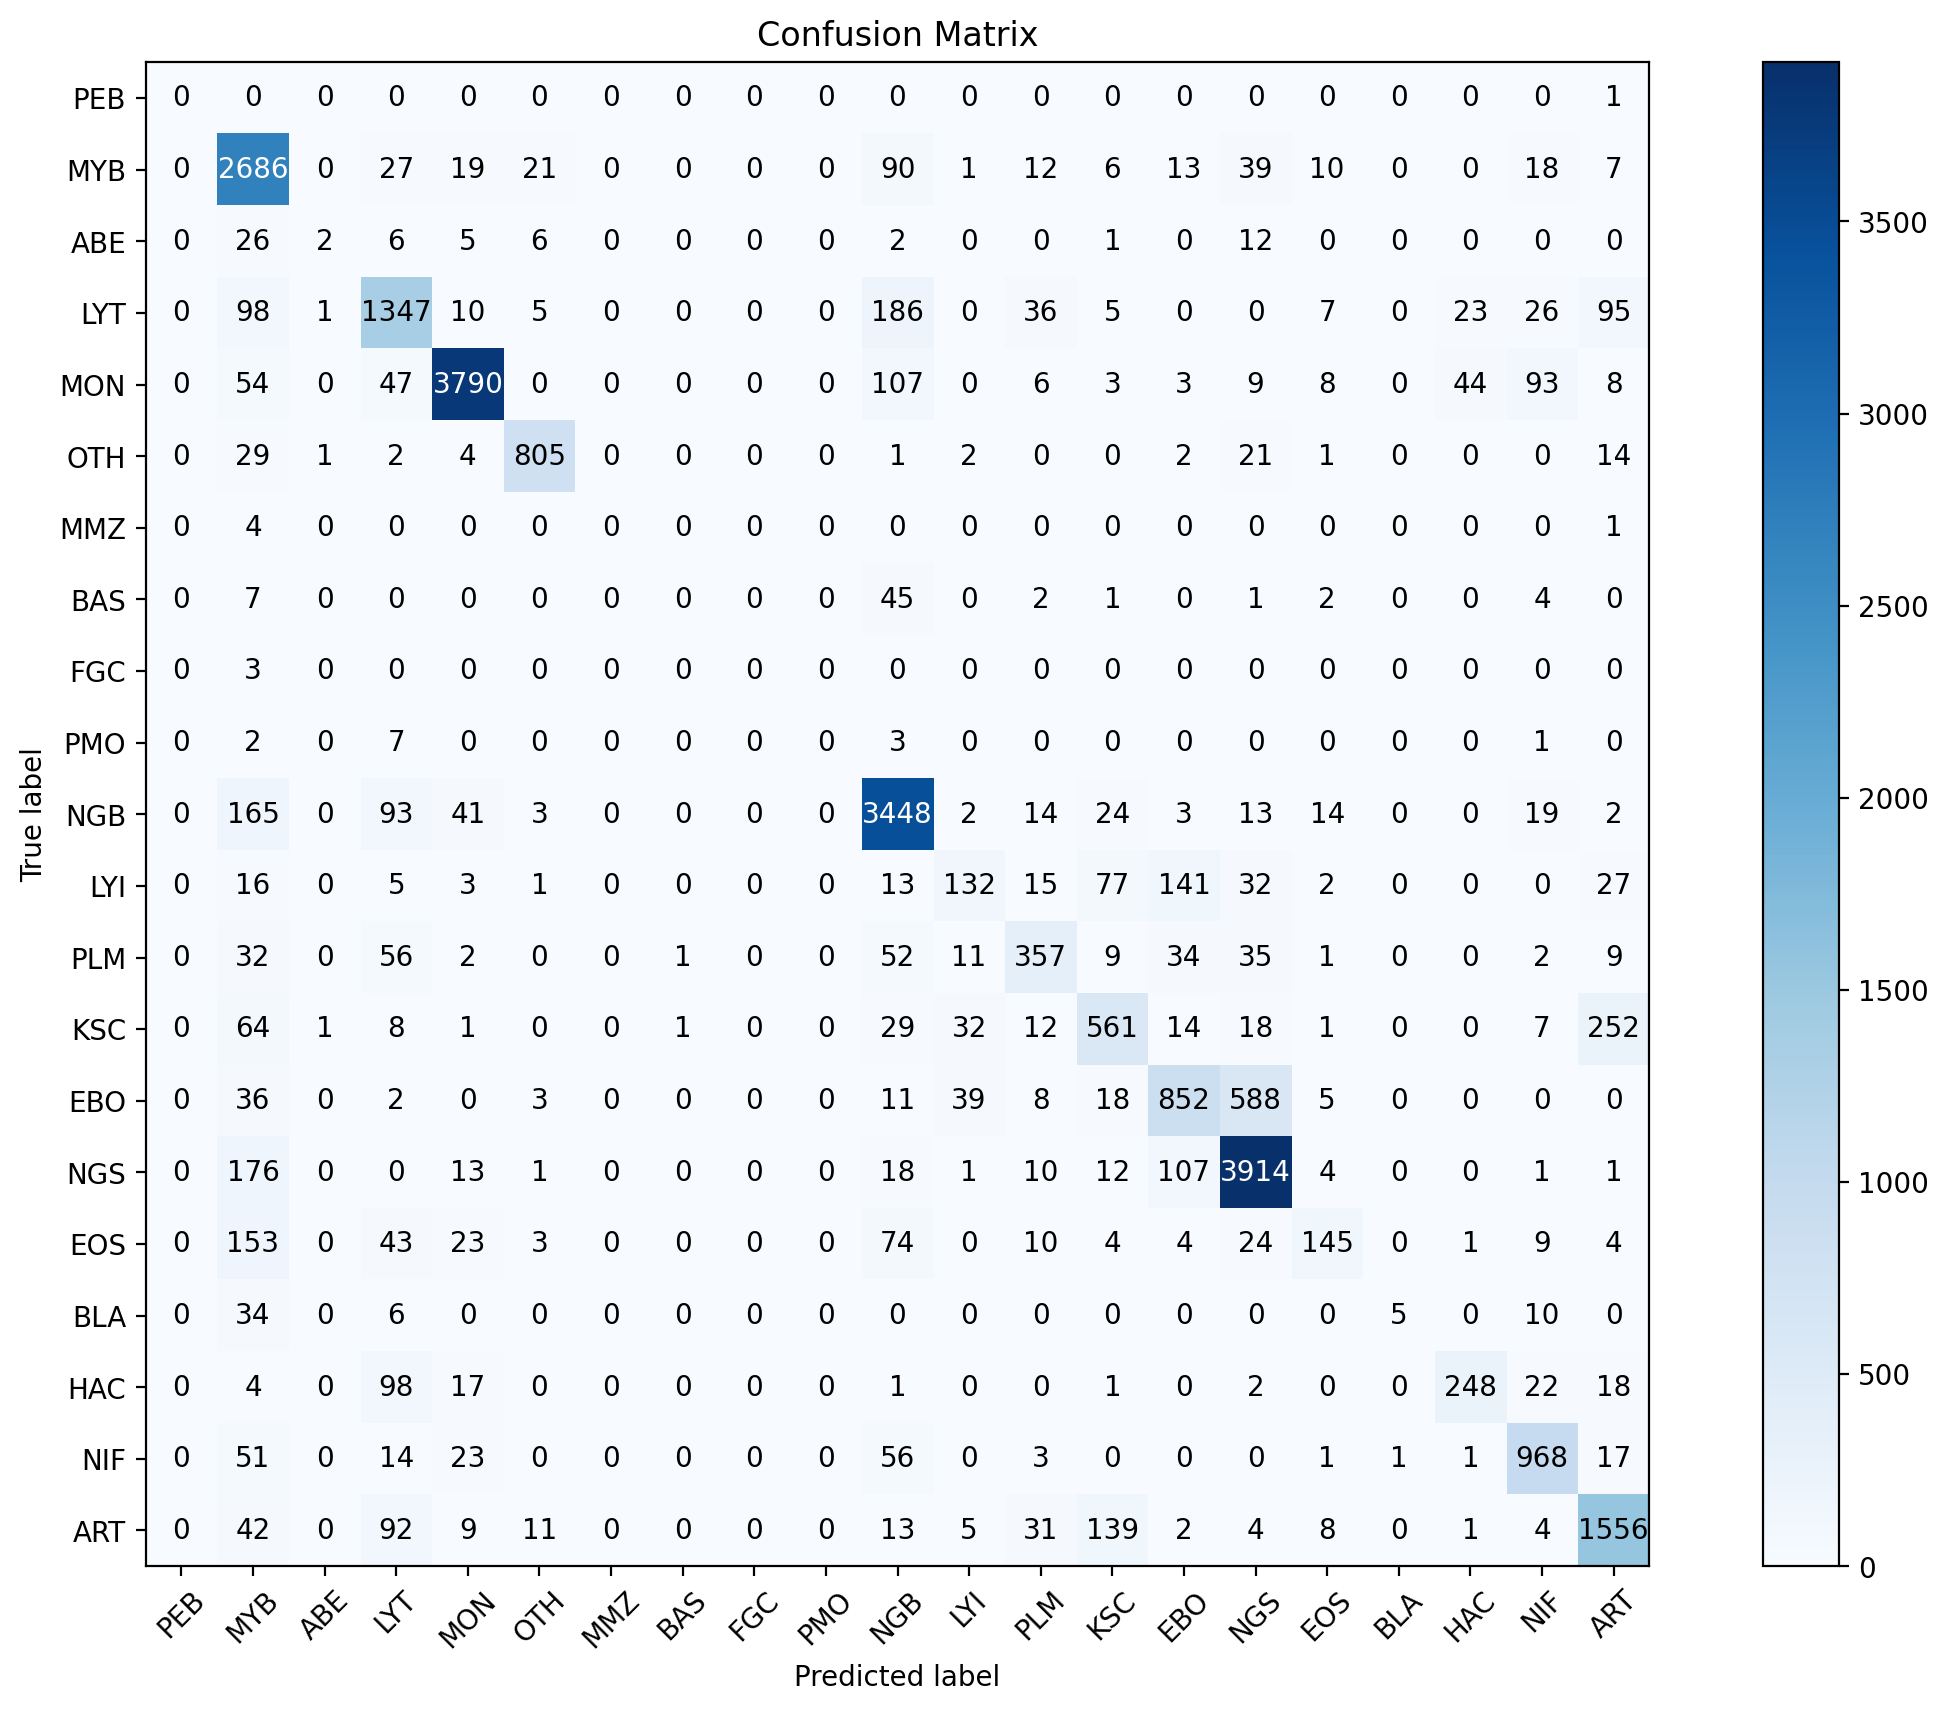

Classification Report:
              precision    recall  f1-score   support

         PEB       0.00      0.00      0.00         1
         MYB       0.73      0.91      0.81      2949
         ABE       0.40      0.03      0.06        60
         LYT       0.73      0.73      0.73      1839
         MON       0.96      0.91      0.93      4172
         OTH       0.94      0.91      0.92       882
         MMZ       0.00      0.00      0.00         5
         BAS       0.00      0.00      0.00        62
         FGC       0.00      0.00      0.00         3
         PMO       0.00      0.00      0.00        13
         NGB       0.83      0.90      0.86      3841
         LYI       0.59      0.28      0.38       464
         PLM       0.69      0.59      0.64       601
         KSC       0.65      0.56      0.60      1001
         EBO       0.73      0.55      0.62      1562
         NGS       0.83      0.92      0.87      4258
         EOS       0.69      0.29      0.41       497
    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# import seaborn as sns
# from matplotlib import pyplot
# from sklearn.metrics import confusion_matrix
# # Get the list of all possible classes
# all_classes = sorted(set(y_true + y_pred + y_train_encoded.tolist()))

# # Calculate confusion matrix with all classes
# conf_matrix = confusion_matrix(y_true, y_pred, labels=all_classes)

# # sns.set(rc={'figure.figsize':(11.7,8.27)})

# # Print confusion matrix
# print("\nConfusion Matrix:")
# pyplot.figure(figsize=(11.7, 8.27),dpi=200)
# conf_matrix = sns.heatmap(conf_matrix,annot=True, fmt='d')
# conf_matrix.figure.savefig('ResNet50_10_epoch.png')
# print(conf_matrix)

# # Calculate classification report
# class_report = classification_report(y_true, y_pred)

# # Print classification report
# print("Classification Report:")
# print(class_report)


import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Get the list of all possible classes
all_classes = sorted(set(y_true + y_pred + y_train_encoded.tolist()))

# Calculate confusion matrix with all classes
conf_matrix = confusion_matrix(y_true, y_pred, labels=all_classes)

# Plot confusion matrix
plt.figure(figsize=(11.7, 8.27), dpi=200)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(all_classes))

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j],
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(tick_marks, unique_classes, rotation=45)
plt.yticks(tick_marks, unique_classes)
plt.savefig('ResNet50_10_epoch.png')
plt.show()

# Calculate classification report
class_report = classification_report(y_true, y_pred,target_names=unique_classes)

# Print classification report
print("Classification Report:")
print(class_report)
